# Visium HD tutorial

We can run Sopa on Visium HD, as the 2 micron bins are subcellular. You can follow the ["normal" API tutorial](../api_usage), or continue below to get exemples more specific to Visium HD data.

For this tutorial, we use the [mouse small intestine public dataset](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine) from 10X Genomics.

In [1]:
import sopa

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
sdata_full = sopa.io.visium_hd("data/visium_hd/Visium_HD_Mouse_Small_Intestine")
sdata_full

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     └── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
└── Tables
      └── 'square_002um': AnnData (5479660, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        Visium_HD_Mouse_Small_Intestine_lowres_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes)
    ▸ 'global', with elements:
        Visium_HD_Mouse_Small_Intestine_full_image (Images), Visium_HD_Mouse_Small_Intest

For simplicity, we crop the dataset (so that the tutorial runs faster).

In [3]:
sdata = sdata_full.query.bounding_box(
    axes=["y", "x"], min_coordinate=[10_000, 10_000], max_coordinate=[15_000, 15_000], target_coordinate_system="global"
)

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then, we save it on-disk:

In [4]:
sdata.write("sub_visium_hd.zarr")

INFO     The Zarr backing store has been changed from None the new file path: sub_visium_hd.zarr                   


Since the tissue is very sparse, we can segment it (i.e., create the contour of the tissue).

In [9]:
sopa.segmentation.tissue(sdata, image_key="Visium_HD_Mouse_Small_Intestine_full_image", expand_radius_ratio=0.01)

We can see the contour of the tissue in red:

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


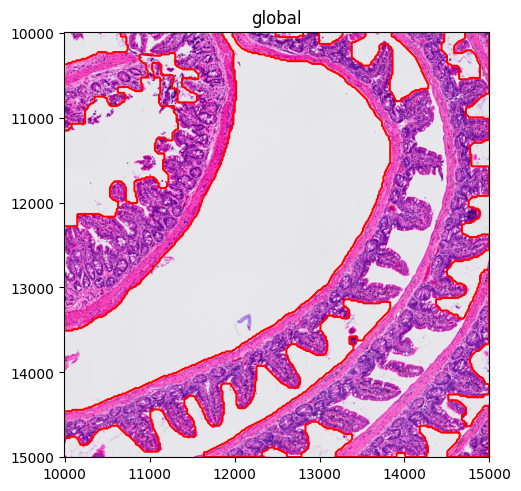

In [10]:
import spatialdata_plot

sdata \
    .pl.render_images() \
    .pl.render_shapes("region_of_interest", outline_alpha=1, outline_color="r", fill_alpha=0) \
    .pl.show()

Then, we create the patches for the cell segmentation.

In [11]:
sopa.make_image_patches(sdata)

[INFO] (sopa.patches._patches) 9 patches were added to sdata['image_patches']


For faster segmentation, we recommend using the `"dask"` parallelization backend:

In [12]:
sopa.settings.parallelization_backend = "dask" # optional
sopa.settings.dask_client_kwargs = {"n_workers": 4} # optional

Now we can run cellpose on the `"r"` channel (from the `rgb` image):

In [ ]:
sopa.segmentation.cellpose(sdata, channels=["r"], diameter=15, min_area=50)

Now, we need to aggregate the bins into the cells. There is an argument `bins_key`, but by default Sopa will understand that it's Visium HD data and that it should use the 2-microns bins.

> On the example below, we only aggregate the bins, not the H&E channels.

In [19]:
sopa.aggregate(sdata, aggregate_channels=False)

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now, we have an AnnData object with the gene expression **per cell**.

In [20]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 26165 × 19059
    obs: 'region', 'slide', 'cell_id', 'area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial'

For instance, we can now use Scanpy to plot gene expression.

In [21]:
import scanpy as sc

In [22]:
# basic preprocessing
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

We can then use `sc.pl.spatial` to show the gene expression per cells. Note that, here, we show **cells**, not bins.

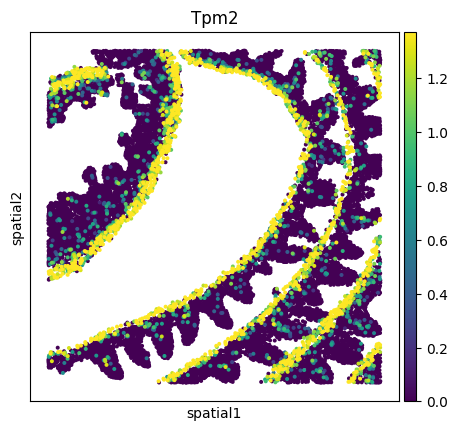

In [23]:
sc.pl.spatial(adata, color="Tpm2", spot_size=60, vmax="p95")